<a href="https://colab.research.google.com/github/karentp/Arduino-GPIO-Giroscopio-comunicaciones-TinyML/blob/main/Lab5TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalar e Importar las Librerías necesarias

In [1]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86.3 MB 35 kB/s 
     |████████████████████████████████| 449 kB 34.2 MB/s 
     |████████████████████████████████| 3.8 MB 13.9 MB/s 
     |████████████████████████████████| 50 kB 1.7 MB/s 
     |████████████████████████████████| 152 kB 39.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3a277a88341c81f7690000f8fbb62ae28e9f5b23ef473c4f464f38f4c4031840
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.2.0
    Uninstalling cachetools-5.2.0:
      Successfully uninstalled cachetools-5.2.0
  Attempting uninstall: google-auth
    Found existing installation: go

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

## Leer el archivo gráficar su comportamiento

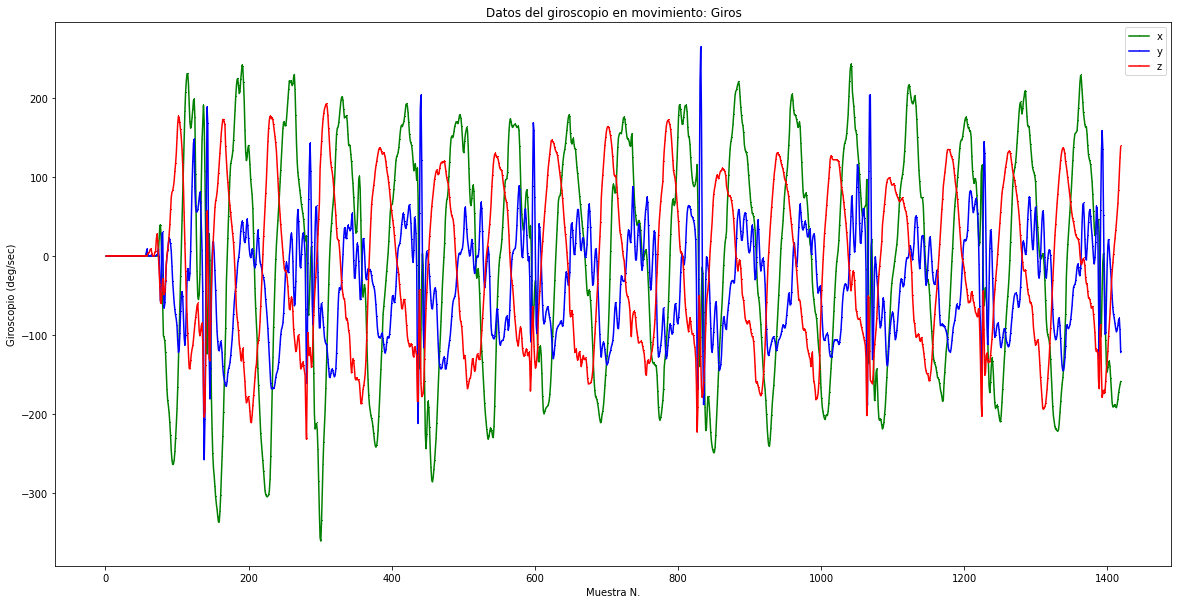

In [6]:
file_data = "giros.csv"
data_frame = pd.read_csv("/content/" + file_data)
index = range(1, len(data_frame['gX']) + 1)


#Grafica de comportamiento
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(index, data_frame['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, data_frame['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, data_frame['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Datos del giroscopio en movimiento: Giros")
plt.xlabel("Muestra N.")
plt.ylabel("Giroscopio (deg/sec)")
plt.legend()
plt.show()

## Preparación y limpieza de datos

In [7]:
#Seed para los numeros random

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

#  Lista de movimientos disponibles
MOVEMENTS = [
    "giros",
    "flex",
]

SAMPLES_PER_MOVE = 119
NUM_MOVEMENTS = len(MOVEMENTS)

# Matriz codificada
ONE_HOT_ENCODED_MOVEMENTS = np.eye(NUM_MOVEMENTS)

inputs = []
outputs = []

# Leer cada csv file y obtener una entrada y una salida
for movement_index in range(NUM_MOVEMENTS):
  movement = MOVEMENTS[movement_index]
  print(f"Procesando  el índice {movement_index} para el movimiento: '{movement}'.")
  
  output = ONE_HOT_ENCODED_MOVEMENTS[movement_index]
  
  data_frame = pd.read_csv("/content/" + movement + ".csv")
  
  # calculate the number of movement recordings in the file
  num_recordings = int(data_frame.shape[0] / SAMPLES_PER_MOVE)
  
  print(f"\tExisten {num_recordings} muestras del movimiento: {movement}.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_MOVE):
      index = i * SAMPLES_PER_MOVE + j
      # Normalizar la salida del giroscopio entre -2mil y 2mil
      tensor += [
          (data_frame['gX'][index] + 2000) / 4000,
          (data_frame['gY'][index] + 2000) / 4000,
          (data_frame['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

print("Preparación de datos lista")

Procesando  el índice 0 para el movimiento: 'giros'.
	Existen 11 muestras del movimiento: giros.
Procesando  el índice 1 para el movimiento: 'flex'.
	Existen 11 muestras del movimiento: flex.
Preparación de datos lista


## Dividir en los sets de entrenamiento, prueba y validación

In [9]:
# Reordenar aleatoriamente las entradas para que no haya sesgo en los datasets
num_inputs = len(inputs)
random_order = np.arange(num_inputs)
np.random.shuffle(random_order)
inputs = inputs[random_order]
outputs = outputs[random_order]

# Dividir en entrenamiento, prueba y validacion
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("División del dataset de entrenamiento, validación y prueba lista")

División del dataset de entrenamiento, validación y prueba lista


## Instanciación del modelo y entrenamiento

In [10]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # usamos como funcion de activación RELU
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_MOVEMENTS, activation='softmax')) # Para backpropagation usamos Softmax
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Train on 13 samples, validate on 5 samples
Epoch 1/600
13/13 [==============================] - 1s 61ms/sample - loss: 0.2998 - mae: 0.5309 - val_loss: 0.2410 - val_mae: 0.4794
Epoch 2/600
13/13 [==============================] - 0s 4ms/sample - loss: 0.2684 - mae: 0.4890 - val_loss: 0.2503 - val_mae: 0.5003
Epoch 3/600
13/13 [==============================] - 0s 3ms/sample - loss: 0.2673 - mae: 0.5148 - val_loss: 0.2412 - val_mae: 0.4857
Epoch 4/600
13/13 [==============================] - 0s 3ms/sample - loss: 0.2708 - mae: 0.5109 - val_loss: 0.2447 - val_mae: 0.4934
Epoch 5/600
13/13 [==============================] - 0s 4ms/sample - loss: 0.2692 - mae: 0.5164 - val_loss: 0.2453 - val_mae: 0.4941
Epoch 6/600
13/13 [==============================] - 0s 4ms/sample - loss: 0.2657 - mae: 0.5145 - val_loss: 0.2417 - val_mae: 0.4871
Epoch 7/600
13/13 [==============================] - 0s 4ms/sample - loss: 0.2677 - mae: 0.5152 - val_loss: 0.2418 - val_mae: 0.4873
Epoch 8/600
13/13 [======

## Gráficas de la pérdida: MAE

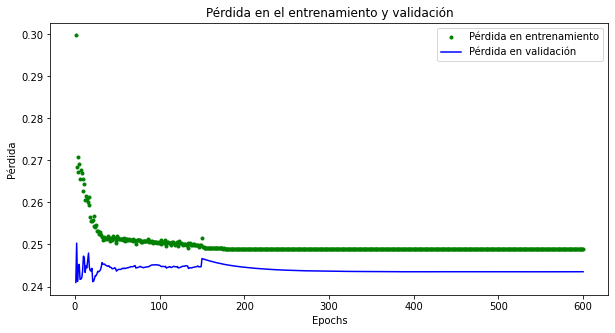

[10.0, 5.0]


In [13]:

plt.rcParams["figure.figsize"] = (10,5)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Pérdida en entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida en validación')
plt.title('Pérdida en el entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

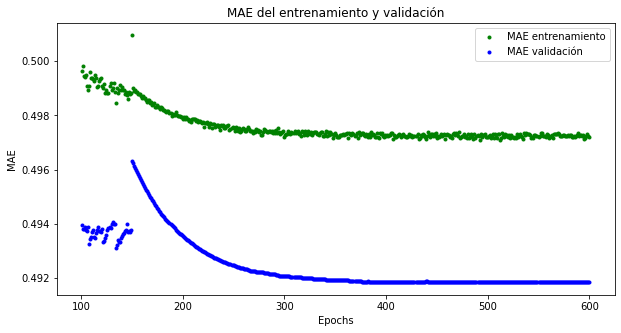

In [15]:
OMIT = 100
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[OMIT:], mae[OMIT:], 'g.', label='MAE entrenamiento')
plt.plot(epochs[OMIT:], val_mae[OMIT:], 'b.', label='MAE validación')
plt.title('MAE del entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Probar con el dataset de TEST

predicciones =
 [[0.459 0.541]
 [0.459 0.541]
 [0.459 0.541]
 [0.459 0.541]]
reales =
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if sys.path[0] == '':


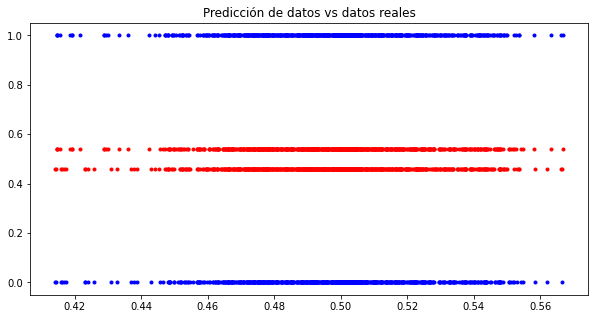

In [18]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predicciones =\n", np.round(predictions, decimals=3))
print("reales =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Predicción de datos vs datos reales')
plt.plot(inputs_test, outputs_test, 'b.', label='Real')
plt.plot(inputs_test, predictions, 'r.', label='Predicción')
plt.show()

## Pasamos el modelo a TensorFlow Lite

In [19]:
converter_to_lite = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite = converter_to_lite.convert()
open("modelo_tensorflow.tflite", "wb").write(tf_lite)

size = os.path.getsize("modelo_tensorflow.tflite")
print("El Modelo tiene un tamaño de %d bytes" % size)
  
  

El Modelo tiene un tamaño de 76400 bytes


In [22]:
!echo "const unsigned char model[] = {" > /content/modelo.h
!cat movement_model.tflite | xxd -i      >> /content/modelo.h
!echo "};"                              >> /content/modelo.h

model_h_size = os.path.getsize("modelo.h")
print(f"Header: , modelo.h, is {model_h_size:,} bytes.")


cat: movement_model.tflite: No such file or directory
Header: , modelo.h, is 35 bytes.
